# Lucas-Kanade Object Tracker

This notebook implements a Lucas-Kanade tracker for object tracking in video sequences. The tracker uses affine transformation parameters to track objects across frames.

## Table of Contents
1. [Import Libraries](#imports)
2. [Lucas-Kanade Tracker Class](#tracker-class)
3. [Utility Functions](#utility-functions)
4. [Main Tracking Function](#main-tracking)
5. [Video Processing Functions](#video-processing)
6. [Run Tracking](#run-tracking)

## 1. Import Libraries {#imports}

Import all necessary libraries for computer vision, numerical computation, and visualization.

In [1]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from IPython.display import clear_output
import time

## 2. Lucas-Kanade Tracker Class {#tracker-class}

The main tracker class that implements the Lucas-Kanade algorithm with affine transformation.

In [2]:
class LucasKanadeTracker:
    def __init__(self, sobel_kernel_size=5, threshold=0.001, max_iterations=200):
        """
        Initialize Lucas-Kanade tracker

        Args:
            sobel_kernel_size: Size of Sobel kernel for gradient computation
            threshold: Convergence threshold for parameter updates
            max_iterations: Maximum number of iterations per frame
        """
        self.threshold = threshold
        self.max_iterations = max_iterations
        self.sobel_kernel_size = sobel_kernel_size

### Gradient Computation

Compute image gradients using Sobel operators for the Lucas-Kanade algorithm.

In [3]:
def compute_gradients(self, image):
    """
    Compute image gradients using Sobel operators

    Args:
        image: Input grayscale image

    Returns:
        gx, gy: Horizontal and vertical gradients
    """
    gx = cv2.Sobel(image.astype(np.float32), cv2.CV_64F, 1, 0, ksize=self.sobel_kernel_size)
    gy = cv2.Sobel(image.astype(np.float32), cv2.CV_64F, 0, 1, ksize=self.sobel_kernel_size)

    return gx, gy

# Add method to the class
LucasKanadeTracker.compute_gradients = compute_gradients

### Affine Transformation

Create affine transformation matrix from 6 parameters.

In [4]:
def affine_warp_matrix(self, p):
    """
    Create affine transformation matrix from parameters

    Args:
        p: 6-parameter vector [p1, p2, p3, p4, p5, p6]

    Returns:
        3x3 affine transformation matrix
    """
    return np.array([
        [1 + p[0], p[2], p[4]],
        [p[1], 1 + p[3], p[5]],
    ])

# Add method to the class
LucasKanadeTracker.affine_warp_matrix = affine_warp_matrix

### Rectangle Update and Image Cropping

Update bounding box coordinates and crop images based on transformation.

In [5]:
def get_updated_rectangle(self, transformation_matrix, input_rectangle, image_width, image_height, image):
    # Top-left corner in homogeneous coordinates
    top_left_homogeneous = np.array([[input_rectangle[0]], [input_rectangle[1]], [1]])

    # Transform top-left corner
    updated_top_left_homogeneous = transformation_matrix @ top_left_homogeneous

    # Extract coordinates ensuring they stay within image boundaries
    updated_top_left_x = max(0, updated_top_left_homogeneous[0, 0])
    updated_top_left_y = max(0, updated_top_left_homogeneous[1, 0])

    # Calculate bottom-right coordinates within image boundaries
    updated_bottom_right_x = min(image.shape[1], updated_top_left_x + image_width)
    updated_bottom_right_y = min(image.shape[0], updated_top_left_y + image_height)
    
    updated_rectangle = [
        int(updated_top_left_x),
        int(updated_top_left_y),
        int(updated_bottom_right_x),
        int(updated_bottom_right_y)
    ]

    return updated_rectangle

def crop_image(self, image, rectangle):
    """
    Crop image to specified rectangle

    Args:
        image: Input image
        rectangle: Bounding box [x, y, w, h]

    Returns:
        Cropped image
    """
    return image[rectangle[1]:rectangle[3], rectangle[0]:rectangle[2]]

# def update_rect(self, W, bbox):
#     x, y, w, h = bbox
#     top = np.array([x, y, 1.]).reshape(3,1)
#     new = (W @ top).ravel()
#     return [int(new[0]), int(new[1]), w, h]
# Add methods to the class
LucasKanadeTracker.get_updated_rectangle = get_updated_rectangle
LucasKanadeTracker.crop_image = crop_image
# LucasKanadeTracker.update_rect = update_rect


### Steepest Descent Computation

Compute steepest descent images for the Lucas-Kanade optimization.

In [6]:
def compute_steepest_descent_warped(self, gx, gy, rect):
    # rows/cols inside ROI
    gradient_descent_vectors = []

    for row in range(rect[1], rect[3]):
        for col in range(rect[0], rect[2]):
            gradient_vector = np.array([gx[row][col], gy[row][col]])
            jacobian_matrix = np.array([[col, 0, row, 0, 1, 0], [0, col, 0, row, 0, 1]])
            gradient_descent_matrix = np.matmul(gradient_vector, jacobian_matrix)
            gradient_descent_vectors.append(gradient_descent_matrix)

    return gradient_descent_vectors

# Add method to the class
LucasKanadeTracker.compute_steepest_descent_warped = compute_steepest_descent_warped

### Main Tracking Algorithm

The core Lucas-Kanade tracking function that processes each frame.

In [7]:
def track_frame(self, template, current_frame, bbox, p_init=None,img_h = 50, img_w = 110):
    """
    Track object in current frame using Lucas-Kanade

    Args:
        template: Template image patch
        current_frame: Current frame
        bbox: Current bounding box estimate
        p_init: Initial parameter estimate

    Returns:
        Updated parameters and bounding box
    """
    if p_init is None:
            p = np.zeros(6)
    else:
        p = p_init.copy()

    
    
    gx, gy = self.compute_gradients(current_frame)
    W = self.affine_warp_matrix(p)
    
    for iteration in range(self.max_iterations):
        W = self.affine_warp_matrix(p)
        updated_rectangle = self.get_updated_rectangle(W, bbox, img_w, img_h, current_frame)
        warpedImage = cv2.warpAffine(current_frame, W, dsize=(current_frame.shape[1], current_frame.shape[0]))
        currentFrame = self.crop_image(warpedImage, updated_rectangle)
        currentFrameHeight, currentFrameWeight = currentFrame.shape
        tempRect = np.array([0, 0, currentFrameWeight, currentFrameHeight])

        # Calculate error between template and current frame
        error = self.crop_image(template, tempRect).astype(int) - currentFrame.astype(int)

        # Compute steepest descent images using warped coordinates
        sd_images = self.compute_steepest_descent_warped(gx, gy, updated_rectangle)
        sd_images = np.array(sd_images)

        # Calculate Hessian matrix
        Hessian = np.matmul(np.transpose(np.array(sd_images)), np.array(sd_images))
        Hessian_inv = np.linalg.pinv(Hessian)

        # Calculate parameter update
        dP = np.matmul(np.matmul(Hessian_inv, np.transpose(np.array(sd_images))), error.reshape(((error.shape[0] * error.shape[1]), 1)))
        p += dP.reshape((-1))
        norm = np.linalg.norm(dP)

        # Check convergence
        if norm <= self.threshold:
            break
            
    bbox = self.get_updated_rectangle(W, bbox, img_w, img_h, current_frame)
    return p, bbox

# Add method to the class
LucasKanadeTracker.track_frame = track_frame

## 3. Utility Functions

Helper functions for bounding box selection and video loading.

### Interactive Bounding Box Selection

Function to interactively select the object to track in the first frame.

In [8]:
def select_bounding_box(frame):
    """
    Interactive bounding box selection

    Args:
        frame: First frame of video

    Returns:
        Selected bounding box [x, y, w, h]
    """
    print("Click and drag to select the object to track. Close the window when done.")

    drawing = False
    bbox = [0, 0, 0, 0]

    def mouse_callback(event, x, y, flags, param):
        nonlocal drawing, bbox

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            bbox[0], bbox[1] = x, y

        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                bbox[2] = x - bbox[0]
                bbox[3] = y - bbox[1]

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            bbox[2] = x - bbox[0]
            bbox[3] = y - bbox[1]

    cv2.namedWindow('Select Object', cv2.WINDOW_AUTOSIZE)
    cv2.setMouseCallback('Select Object', mouse_callback)

    while True:
        img_copy = frame.copy()
        if bbox[2] > 0 and bbox[3] > 0:
            cv2.rectangle(img_copy, (bbox[0], bbox[1]), 
                         (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 2)

        cv2.imshow('Select Object', img_copy)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or cv2.getWindowProperty('Select Object', cv2.WND_PROP_VISIBLE) < 1:
            break

    cv2.destroyAllWindows()

    # Ensure positive width and height
    if bbox[2] < 0:
        bbox[0] += bbox[2]
        bbox[2] = -bbox[2]
    if bbox[3] < 0:
        bbox[1] += bbox[3]
        bbox[3] = -bbox[3]

    return bbox

### Video Loading Function

Load video data from numpy array files.

In [9]:
def load_video_from_npy(filename):
    """
    Load video from numpy array file

    Args:
        filename: Path to .npy file

    Returns:
        Video frames as numpy array
    """
    video = np.load(filename)
    return video

## 4. Main Tracking Function {#main-tracking}

The main function that coordinates the entire tracking process.

In [10]:
def track_object_in_video(video_path, output_path=None):
    """
    Main tracking function

    Args:
        video_path: Path to input video (.npy file)
        output_path: Path to save output video (optional)

    Returns:
        List of bounding boxes for each frame
    """
    print(f"Loading video from {video_path}...")
    frames = load_video_from_npy(video_path)

    if len(frames.shape) == 4:  # Color video
        gray_frames = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in frames])
    else:  # Already grayscale
        gray_frames = frames

    print(f"Video loaded: {frames.shape[2]} frames, {frames.shape[0]}x{frames.shape[1]}")

    gray_frames = gray_frames.transpose(2, 0, 1)
    
    first_frame = frames[0] if len(frames.shape) == 4 else cv2.cvtColor(gray_frames[0], cv2.COLOR_GRAY2RGB)
    bbox = select_bounding_box(first_frame)

    print(f"Selected bounding box: {bbox}")

    tracker = LucasKanadeTracker()

    x, y, w, h = bbox
    template = gray_frames[0][y:y+h, x:x+w].astype(np.float32)

    bboxes = [bbox]
    current_bbox = bbox.copy()
    p = np.zeros(6)  # Initial affine parameters

    print("Tracking object through video...")

    for i in range(1, len(gray_frames)):
        if i % 10 == 0:
            print(f"Processing frame {i}/{len(gray_frames)}")

        current_frame = gray_frames[i].astype(np.float32)
        p, current_bbox = tracker.track_frame(template, current_frame, current_bbox, p,x,y)

        bboxes.append(current_bbox)
        p = np.zeros(6)

    if output_path:
        frames = frames.transpose(2, 0, 1)
        save_tracking_video(frames, bboxes, output_path)

    return bboxes

## 5. Video Processing Functions {#video-processing}

Functions for saving tracking results as video files.

In [11]:
def save_tracking_video(frames, bboxes, output_path, fps=10):
    """
    Save tracking results as video file

    Args:
        frames: Original video frames
        bboxes: List of bounding boxes for each frame
        output_path: Output video file path
        fps: Frames per second
    """
    if len(frames.shape) == 3:  # Grayscale
        height, width = frames.shape[1], frames.shape[2]
        color_frames = np.stack([frames] * 3, axis=-1)
    else:  # Color
        height, width = frames.shape[1], frames.shape[2]
        color_frames = frames

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for i, (frame, bbox) in enumerate(zip(color_frames, bboxes)):
        frame_copy = frame.copy()
        if len(frame_copy.shape) == 2 or frame_copy.shape[2] == 1:
            frame_copy = cv2.cvtColor(frame_copy, cv2.COLOR_GRAY2BGR)

        x, y, w, h = [int(v) for v in bbox]
        cv2.rectangle(frame_copy, (x, y), (w, h), (0, 255, 0), 2)

        cv2.putText(frame_copy, f'Frame {i}', (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        out.write(frame_copy)

    out.release()
    print(f"Tracking video saved to {output_path}")

## 6. Run Tracking

Execute the tracking algorithm on your video data.

### Create Output Directory

Make sure the output directory exists for saving results.

In [12]:
import os

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)
print("Output directory created/confirmed.")

Output directory created/confirmed.


### Track Car Video

Run the tracker on the car video sequence.

In [14]:
print("=== Tracking Car ===")
car_bboxes = track_object_in_video("data/car2.npy", "output/car_tracked.mp4")
print(f"Car tracking completed: {len(car_bboxes)} frames")

=== Tracking Car ===
Loading video from data/car2.npy...
Video loaded: 415 frames, 240x320
Click and drag to select the object to track. Close the window when done.
Selected bounding box: [52, 108, 105, 56]
Tracking object through video...


ValueError: operands could not be broadcast together with shapes (52,105) (52,108) 

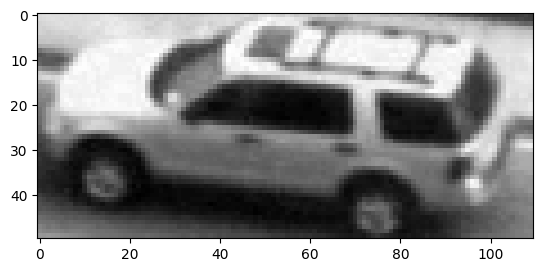

100%|██████████| 415/415 [1:51:22<00:00, 16.10s/it]    


In [79]:

from tqdm import tqdm
def process_video(car_video, template, rect_car, output_path):
    # Get the height and width of the video frames
    h, w = car_video[:, :, 0].shape

    # Define the codec and create a video writer object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, 25.0, (w, h))

    # Get the total number of frames in the video
    total_frames = car_video.shape[2]
    tracker = LucasKanadeTracker()

    # Iterate through frames with tqdm for a progress bar
    for i in tqdm(range(total_frames)):
        # Initialize Lucas-Kanade parameters
        p = np.zeros(6)

        # Extract current frame
        current_frame = car_video[:, :, i].copy()

        # Apply Lucas-Kanade method
        p, box= tracker.track_frame(template, current_frame, rect_car, p,50,110)
        topLeftX, topLeftY, bottomRightX, bottomRightY  = box
        # p, topLeftX, topLeftY, bottomRightX, bottomRightY = LucasKanade(
        #     current_frame, template, rect_car, p, 0.001, 200, 110, 50
        # )

        # Update rectangle coordinates
        rect_car = [int(topLeftX), int(topLeftY), int(bottomRightX), int(bottomRightY)]

        # Draw rectangle on the frame
        output_frame = cv2.rectangle(
            current_frame,
            (int(topLeftX), int(topLeftY)),
            (int(bottomRightX), int(bottomRightY)),
            (0, 0, 0),  # Rectangle color in BGR format (0, 0, 0 for black)
            2,  # Thickness of the rectangle
        )

        # Convert frame to RGB for video writing
        output_frame = cv2.cvtColor(output_frame, cv2.COLOR_GRAY2RGB)

        # Write the processed frame to the output video
        out.write(output_frame)

    # Release the video writer
    out.release()


car_video = load_video_from_npy("data/car2.npy")

rect_car = np.array([50, 110, 160, 160])
template = car_video[:,:,0][rect_car[1]:rect_car[3], rect_car[0]:rect_car[2]]
plt.imshow(template, cmap='gray')
plt.show()
process_video(car_video, template, rect_car, "output/car2.mp4")

### Track Helicopter Video (Optional)

Uncomment the following cell to track the helicopter video as well.

In [56]:
# Uncomment to track helicopter video
# print("\n=== Tracking Helicopter ===")
# helicopter_bboxes = track_object_in_video("data/helicopter.npy", "output/helicopter_tracked.mp4")
# print(f"Helicopter tracking completed: {len(helicopter_bboxes)} frames")

### Display Results

Show some statistics about the tracking results.

In [57]:
# Display tracking statistics
print("\n=== Tracking Results ===")
print(f"Car tracking: {len(car_bboxes)} frames processed")
print(f"First bounding box: {car_bboxes[0]}")
print(f"Last bounding box: {car_bboxes[-1]}")
print("\nTracking completed successfully!")


=== Tracking Results ===
Car tracking: 415 frames processed
First bounding box: [51, 106, 106, 56]
Last bounding box: [28, 128, 134, 179]

Tracking completed successfully!


### Visualize Tracking Results (Optional)

Plot the trajectory of the tracked object center over time.

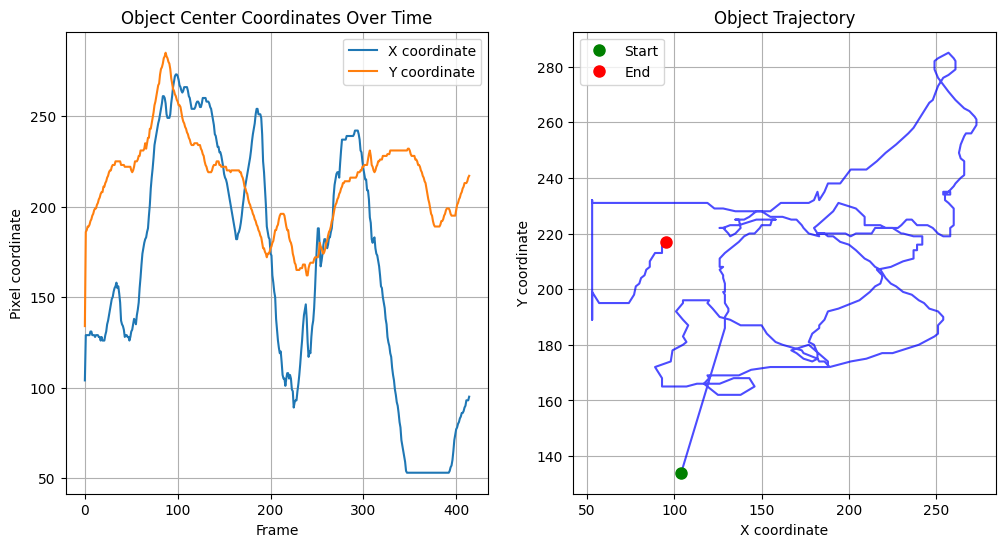

In [ ]:
# Extract center coordinates for visualization
centers_x = [bbox[0] + bbox[2]//2 for bbox in car_bboxes]
centers_y = [bbox[1] + bbox[3]//2 for bbox in car_bboxes]

# Plot trajectory
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(centers_x, label='X coordinate')
plt.plot(centers_y, label='Y coordinate')
plt.xlabel('Frame')
plt.ylabel('Pixel coordinate')
plt.title('Object Center Coordinates Over Time')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(centers_x, centers_y, 'b-', alpha=0.7)
plt.plot(centers_x[0], centers_y[0], 'go', markersize=8, label='Start')
plt.plot(centers_x[-1], centers_y[-1], 'ro', markersize=8, label='End')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Object Trajectory')
plt.legend()
plt.grid(True)
plt.show()